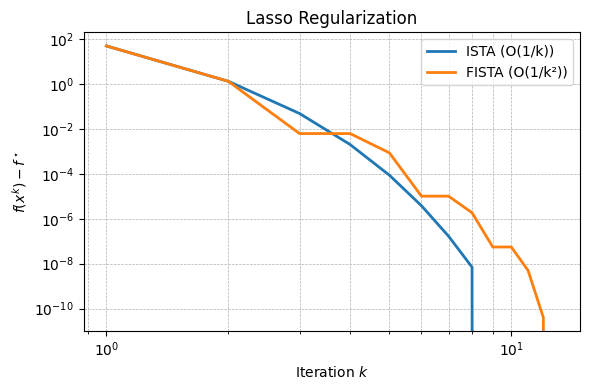

[LASSO] Skipped L-BFGS: L-BFGS only supports 'ridge' or 'elasticnet' (with alpha1 ≈ 0).


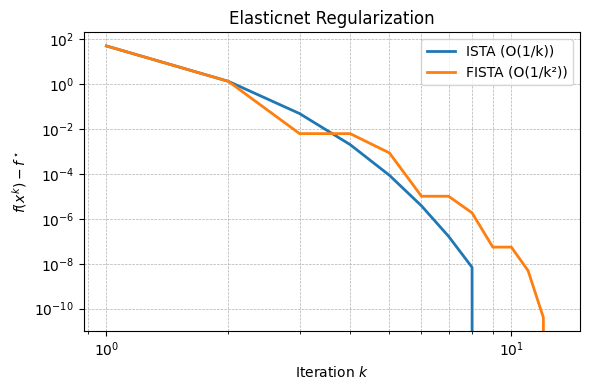

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.


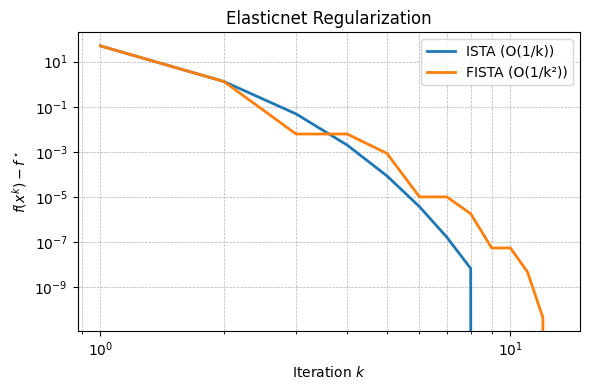

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.
[ELASTICNET] Skipped ISTA/FISTA: alpha1 ≈ 0 → smooth-only. Use L-BFGS.
[RIDGE] Skipped ISTA/FISTA: unsupported reg_type


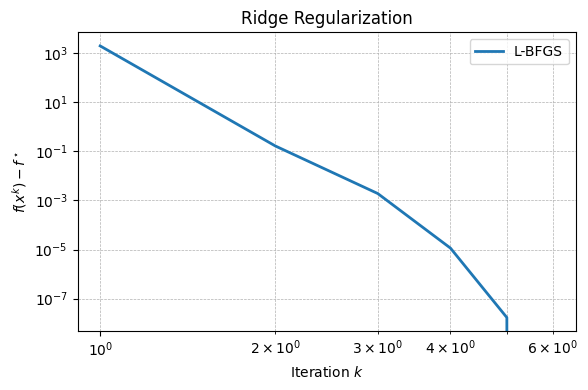

   method regularizer     alpha1     alpha2  n_iter     time_s     f_final  \
0    ISTA       lasso 0.50000000 0.00000000      10 0.00134133  7.10827126   
1   FISTA       lasso 0.50000000 0.00000000      13 0.00074463  7.10827126   
2    ISTA  elasticnet 0.20000000 0.05000000      10 0.00119554  5.74996808   
3   FISTA  elasticnet 0.20000000 0.05000000      13 0.00069167  5.74996808   
4    ISTA  elasticnet 0.00010000 0.50000000      10 0.00203396  9.06887979   
5   FISTA  elasticnet 0.00010000 0.50000000      13 0.00070071  9.06887979   
6  L-BFGS  elasticnet 0.00000000 0.50000000       6 0.00471125  9.06825844   
7  L-BFGS       ridge 0.00000000 1.00000000       6 0.00040904 14.12558435   

   error_norm  
0  9.37114545  
1  9.37114545  
2  9.37096252  
3  9.37096252  
4  9.37229331  
5  9.37229330  
6  9.37229366  
7  9.37403446  


In [39]:

# imports
from importlib import reload
import iterative_solvers
reload(iterative_solvers)
from iterative_solvers import fista_delta
from easy_boston_data import generate_easy_boston_like_data
from iterative_solvers import ista, fista
from lbfgs import LBFGSSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) data gen + standardization
A, b, x_true = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std
b = b - b.mean()

# 2) Lasso, Elastic-Net, Ridge
reg_settings = [
    {"name": "lasso",      "alpha1": 0.5,   "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 0.2,   "alpha2": 0.05},
    {"name": "elasticnet", "alpha1": 1e-4,  "alpha2": 0.5},
    {"name": "elasticnet", "alpha1": 0.0,   "alpha2": 0.5},
    {"name": "ridge",      "alpha1": 0.0,   "alpha2": 1.0}
]

records = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    # --- ISTA / FISTA solo se valido ---
    if name in ("lasso", "elasticnet"):
        if name == "elasticnet" and a1 < 1e-6:
            print(f"[{name.upper()}] Skipped ISTA/FISTA: alpha1 ≈ 0 → smooth-only. Use L-BFGS.")
        else:
            try:
                # ISTA
                t0 = time.perf_counter()
                x_ista, obj_ista = ista(A, b,
                                        reg_type=name,
                                        alpha1=a1,
                                        alpha2=a2,
                                        max_iter=500)
                t_ista = time.perf_counter() - t0

                # FISTA
                t0 = time.perf_counter()
                x_fista, obj_fista = fista(A, b,
                                           reg_type=name,
                                           alpha1=a1,
                                           alpha2=a2,
                                           max_iter=500)
                t_fista = time.perf_counter() - t0

                # approximate best f*
                f_star = obj_fista[-1]

                # plot convergence
                gap_ista  = np.array(obj_ista)  - f_star
                gap_fista = np.array(obj_fista) - f_star
                env_ista  = np.minimum.accumulate(gap_ista)
                env_fista = np.minimum.accumulate(gap_fista)
                ks_ista  = np.arange(1, len(env_ista) + 1)
                ks_fista = np.arange(1, len(env_fista) + 1)

                fig, ax = plt.subplots(figsize=(6, 4))
                ax.loglog(ks_ista, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
                ax.loglog(ks_fista, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)
                ax.set_title(f"{name.title()} Regularization")
                ax.set_xlabel("Iteration $k$")
                ax.set_ylabel(r"$f(x^k)-f^\star$")
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax.legend()
                plt.tight_layout()
                plt.show()

                records.append({
                    "method":      "ISTA",
                    "regularizer": name,
                    "alpha1": a1,
                    "alpha2": a2,
                    "n_iter":      len(obj_ista),
                    "time_s":      t_ista,
                    "f_final":     obj_ista[-1],
                    "error_norm":  np.linalg.norm(x_ista - x_true)
                })

                records.append({
                    "method":      "FISTA",
                    "regularizer": name,
                    "alpha1": a1,
                    "alpha2": a2,
                    "n_iter":      len(obj_fista),
                    "time_s":      t_fista,
                    "f_final":     obj_fista[-1],
                    "error_norm":  np.linalg.norm(x_fista - x_true)
                })

            except ValueError as e:
                print(f"[{name.upper()}] Skipped ISTA/FISTA: {e}")
    else:
        print(f"[{name.upper()}] Skipped ISTA/FISTA: unsupported reg_type")

    # --- L-BFGS sempre tentato se valido ---
    try:
        solver = LBFGSSolver(reg_type=name, alpha1=a1, alpha2=a2)
        t0 = time.perf_counter()
        solver.fit(A, b)
        t_lbfgs = time.perf_counter() - t0

        records.append({
            "method":      "L-BFGS",
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter":      len(solver.history_),
            "time_s":      t_lbfgs,
            "f_final":     solver.final_obj_,
            "error_norm":  np.linalg.norm(solver.x_ - x_true)
        })

        if name == "ridge":
            obj_vals = solver.history_
            f_star = solver.final_obj_
            gap_lbfgs = np.array(obj_vals) - f_star
            env_lbfgs = np.minimum.accumulate(gap_lbfgs)
            ks = np.arange(1, len(env_lbfgs)+1)

            fig, ax = plt.subplots(figsize=(6, 4))
            ax.loglog(ks, env_lbfgs, '-', label="L-BFGS", linewidth=2)
            ax.set_title("Ridge Regularization")
            ax.set_xlabel("Iteration $k$")
            ax.set_ylabel(r"$f(x^k)-f^\star$")
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.legend()
            plt.tight_layout()
            plt.show()

    except ValueError as e:
        print(f"[{name.upper()}] Skipped L-BFGS: {e}")


# Final table
df_summary = pd.DataFrame(records)
print(df_summary)


### 📋 Table Explanation – Optimization Results

Each row of the summary tables reports the performance of a given optimization method (e.g., ISTA, FISTA, FISTA-Delta, L-BFGS) applied to a specific regularization configuration.

#### 🔢 Columns:

- **method**: the algorithm used (`ISTA`, `FISTA`, `FISTA-DELTA`, `L-BFGS`)
- **regularizer**: type of regularization (`lasso`, `elasticnet`, or `ridge`)
- **alpha1**: coefficient of L1 regularization (sparsity)
- **alpha2**: coefficient of L2 regularization (ridge)
- **reg_group**: assigned group label based on regularization parameters:
  - `"EN-1"` → Elastic Net with strong L1 (e.g., alpha1 = 0.2)
  - `"EN-2"` → Elastic Net with weak L1 (e.g., alpha1 ≈ 1e-4)
  - `"EN-3"` → Elastic Net degenerate to Ridge (alpha1 = 0)
  - `"lasso"` or `"ridge"` explicitly labeled
- **n_iter**: number of iterations until stopping (based on step norm < ε)
- **time_s**: wall-clock runtime in seconds
- **f_final**: final objective value reached
- **f_opt**: best known value for this problem group
- **gap**: difference `f_final - f_opt` (non-negative)
- **converged**: boolean flag indicating whether `gap < 1e-6`
- **error_norm**: Euclidean norm `‖x - x_true‖`, i.e., distance to ground truth
- **delta** (only for FISTA-Delta): controls the inertial weight θₖ

These tables allow accurate comparison across solvers and problem regimes.


In [40]:
opt_per_group = df_summary.groupby(["regularizer", "alpha1", "alpha2"])["f_final"].min().rename("f_opt")
df_final = df_summary.merge(opt_per_group, on=["regularizer", "alpha1", "alpha2"])
df_final["gap"] = df_final["f_final"] - df_final["f_opt"]
df_final["converged"] = df_final["gap"] < 1e-6

def classify_group(row):
    if row["regularizer"] == "ridge":
        return "ridge"
    elif row["regularizer"] == "lasso":
        return "lasso"
    elif row["regularizer"] == "elasticnet":
        if np.isclose(row["alpha1"], 0.2, rtol=0, atol=1e-8):
            return "EN-1"
        elif np.isclose(row["alpha1"], 1e-4, rtol=0, atol=1e-8):
            return "EN-2"
        elif np.isclose(row["alpha1"], 0.0, rtol=0, atol=1e-12):
            return "EN-3"
        else:
            return "elasticnet-other"
    else:
        return row["regularizer"]



df_final["reg_group"] = df_final.apply(classify_group, axis=1)

cols = list(df_final.columns)
idx_alpha2 = cols.index("alpha2")
cols = cols[:idx_alpha2+1] + ["reg_group"] + cols[idx_alpha2+1:-1]  + [cols[-1]] if cols[-1] != "reg_group" else cols
df_final = df_final[cols]

df_final


,method,regularizer,alpha1,alpha2,n_iter,time_s,f_final,error_norm,f_opt,gap,converged,reg_group
0,ISTA,lasso,0.50000000,0.00000000,10,0.00134133,7.10827126,9.37114545,7.10827126,0.00000000,True,lasso
1,FISTA,lasso,0.50000000,0.00000000,13,0.00074463,7.10827126,9.37114545,7.10827126,0.00000000,True,lasso
2,ISTA,elasticnet,0.20000000,0.05000000,10,0.00119554,5.74996808,9.37096252,5.74996808,0.00000000,True,EN-1
3,FISTA,elasticnet,0.20000000,0.05000000,13,0.00069167,5.74996808,9.37096252,5.74996808,0.00000000,True,EN-1
4,ISTA,elasticnet,0.00010000,0.50000000,10,0.00203396,9.06887979,9.37229331,9.06887979,0.00000000,True,EN-2
5,FISTA,elasticnet,0.00010000,0.50000000,13,0.00070071,9.06887979,9.37229330,9.06887979,0.00000000,True,EN-2
6,L-BFGS,elasticnet,0.00000000,0.50000000,6,0.00471125,9.06825844,9.37229366,9.06825844,0.00000000,True,EN-3
7,L-BFGS,ridge,0.00000000,1.00000000,6,0.00040904,14.12558435,9.37403446,14.12558435,0.00000000,True,ridge


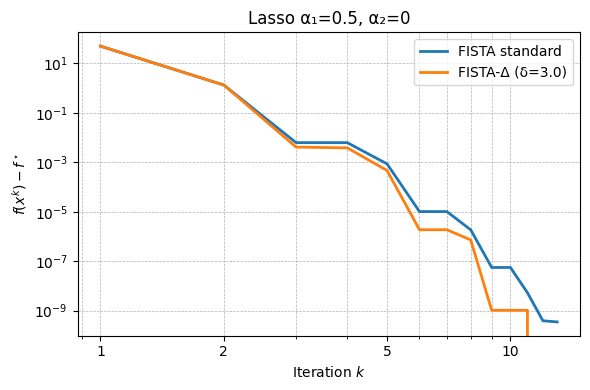

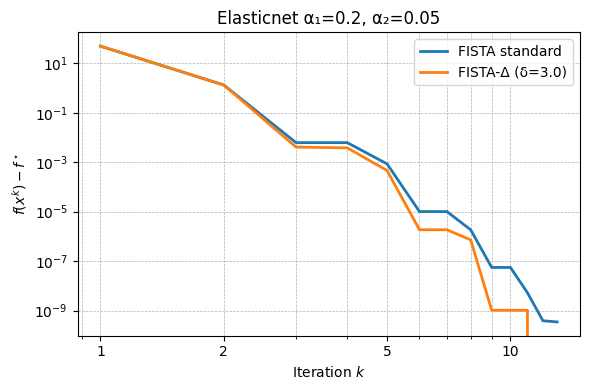

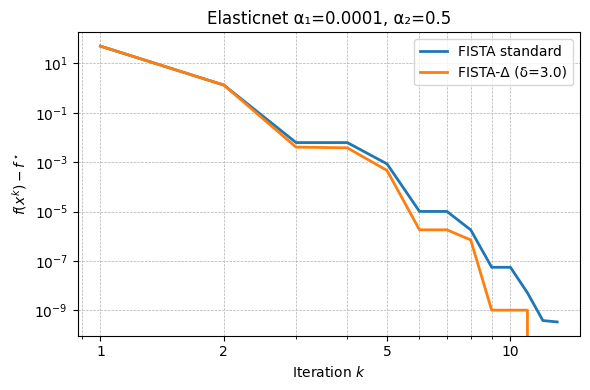

In [41]:
# Confronto FISTA vs FISTA-Delta per ogni setting valido
delta = 3.0
records_fista_variants = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    if name not in ("lasso", "elasticnet") or a1 < 1e-6:
        continue  # Skip smooth-only cases

    try:
        # FISTA standard
        t0 = time.perf_counter()
        x_std, obj_std = fista(A, b,
                               reg_type=name,
                               alpha1=a1,
                               alpha2=a2,
                               max_iter=500)
        t_std = time.perf_counter() - t0

        # FISTA-delta
        t0 = time.perf_counter()
        x_del, obj_del = fista_delta(A, b,
                                     reg_type=name,
                                     alpha1=a1,
                                     alpha2=a2,
                                     delta=delta,
                                     max_iter=500)
        t_del = time.perf_counter() - t0

        # f_star = best value among both
        f_star = min(obj_std[-1], obj_del[-1])

        # Salva i dati nella tabella
        records_fista_variants.append({
            "method": "FISTA",
            "delta": None,
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter": len(obj_std),
            "time_s": t_std,
            "f_final": obj_std[-1],
            "gap": obj_std[-1] - f_star,
            "error_norm": np.linalg.norm(x_std - x_true)
        })

        records_fista_variants.append({
            "method": "FISTA-DELTA",
            "delta": delta,
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter": len(obj_del),
            "time_s": t_del,
            "f_final": obj_del[-1],
            "gap": obj_del[-1] - f_star,
            "error_norm": np.linalg.norm(x_del - x_true)
        })

        # --- plot ---
        gap_std   = np.array(obj_std) - f_star
        gap_del   = np.array(obj_del) - f_star
        env_std   = np.minimum.accumulate(gap_std)
        env_del   = np.minimum.accumulate(gap_del)

        ks_std = np.arange(1, len(env_std)+1)
        ks_del = np.arange(1, len(env_del)+1)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.loglog(ks_std, env_std, '-', label="FISTA standard", linewidth=2)
        ax.loglog(ks_del, env_del, '-', label=f"FISTA-Δ (δ={delta})", linewidth=2)

        ax.set_title(f"{name.title()} α₁={a1:.1g}, α₂={a2:.1g}")
        ax.set_xlabel("Iteration $k$")
        ax.set_ylabel(r"$f(x^k)-f^\star$")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        from matplotlib.ticker import LogLocator, FormatStrFormatter
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 5]))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1, 10), numticks=12))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"[{name.upper()}] Skipped FISTA/FISTA-delta comparison: {e}")


### ⚡ FISTA vs FISTA-Delta (δ = 3.0)

This table compares two accelerated first-order methods:

- **FISTA** (Fast Iterative Shrinkage-Thresholding Algorithm), which uses a standard Nesterov-style momentum based on a recursive parameter \( t_k \)
- **FISTA-Delta**, a variant that replaces the recursive update with a closed-form formula controlled by a constant \( \delta > 2 \)

#### 🔁 Inertial Parameter:

In FISTA-Delta, the momentum coefficient is:

\[
\theta_k = \frac{k}{k+1+\delta} \quad \text{with} \quad \delta = 3.0
\]

This provides a more stable inertial term, with the same theoretical convergence rate \( \mathcal{O}(1/k^2) \), and may improve practical performance in some settings.

Each row shows the behavior of one method (FISTA or FISTA-Delta) applied to a regularization configuration, with detailed metrics including objective gap, convergence, and error norm.

This lets us evaluate whether the modified momentum improves speed, stability, or accuracy in different regimes (Lasso, EN-1, EN-2, EN-3).


In [42]:
df_fista_variants = pd.DataFrame(records_fista_variants)

# 1. f* ottimo stimato per ogni combinazione (ignora metodo)
opt_per_group = df_fista_variants.groupby(["regularizer", "alpha1", "alpha2"])["f_final"].min().rename("f_opt")
df_fv = df_fista_variants.merge(opt_per_group, on=["regularizer", "alpha1", "alpha2"])

# 2. gap e convergenza
df_fv["gap"] = df_fv["f_final"] - df_fv["f_opt"]
df_fv["converged"] = df_fv["gap"] < 1e-6

# 3. classificazione in gruppi logici
def classify_group(row):
    if row["regularizer"] == "ridge":
        return "ridge"
    elif row["regularizer"] == "lasso":
        return "lasso"
    elif row["regularizer"] == "elasticnet":
        if np.isclose(row["alpha1"], 0.2, rtol=0, atol=1e-8):
            return "EN-1"
        elif np.isclose(row["alpha1"], 1e-4, rtol=0, atol=1e-8):
            return "EN-2"
        elif np.isclose(row["alpha1"], 0.0, rtol=0, atol=1e-12):
            return "EN-3"
        else:
            return "elasticnet-other"
    else:
        return row["regularizer"]

df_fv["reg_group"] = df_fv.apply(classify_group, axis=1)

# 4. metti reg_group subito dopo alpha2
cols = list(df_fv.columns)
idx_alpha2 = cols.index("alpha2")
cols = cols[:idx_alpha2+1] + ["reg_group"] + [c for c in cols if c not in cols[:idx_alpha2+1] + ["reg_group"]]
df_fv = df_fv[cols]

df_fv


,method,delta,regularizer,alpha1,alpha2,reg_group,n_iter,time_s,f_final,gap,error_norm,f_opt,converged
0,FISTA,NaN,lasso,0.50000000,0.00000000,lasso,13,0.00141662,7.10827126,0.00000000,9.37114545,7.10827126,True
1,FISTA-DELTA,3.00000000,lasso,0.50000000,0.00000000,lasso,13,0.00071496,7.10827126,0.00000000,9.37114588,7.10827126,True
2,FISTA,NaN,elasticnet,0.20000000,0.05000000,EN-1,13,0.00104675,5.74996808,0.00000000,9.37096252,5.74996808,True
3,FISTA-DELTA,3.00000000,elasticnet,0.20000000,0.05000000,EN-1,13,0.00082333,5.74996808,0.00000000,9.37096295,5.74996808,True
4,FISTA,NaN,elasticnet,0.00010000,0.50000000,EN-2,13,0.00113358,9.06887979,0.00000000,9.37229330,9.06887979,True
5,FISTA-DELTA,3.00000000,elasticnet,0.00010000,0.50000000,EN-2,13,0.00068708,9.06887979,0.00000000,9.37229373,9.06887979,True


### 🔁 FISTA vs Dual FISTA on Lasso problems

This section compares **FISTA** (primal) and **Dual FISTA** on a series of **Lasso configurations**, where the objective is:

\[
\min_{x \in \mathbb{R}^n} \; \tfrac{1}{2} \|Ax - b\|^2 + \alpha_1 \|x\|_1
\]

The corresponding **dual problem**, as derived in the slides, is:

\[
\min_{\lambda \in \mathbb{R}^m} \; \tfrac{1}{2} \|\lambda\|^2 + b^\top \lambda \quad \text{subject to} \quad \|A^\top \lambda\|_\infty \leq \alpha_1
\]

#### Why this comparison is meaningful:
- The **primal and dual solutions are connected** via \( x = A^\top \lambda \)
- The objective values should match: \( f_{\text{primal}}(x) \approx f_{\text{dual}}(x = A^\top \lambda) \)
- The **duality gap** is used as a stopping criterion in Dual FISTA

We test the two methods on different values of \( \alpha_1 \), ranging from weak to strong ℓ₁ regularization:

1. \( \alpha_1 = 0.3 \)
2. \( \alpha_1 = 0.5 \)
3. \( \alpha_1 = 0.8 \)
4. \( \alpha_1 = 1.0 \)

Each run includes:
- A **log-log plot** showing \( f(x^k) - f^\star \) convergence for both methods
- A **summary table** reporting final value, number of iterations, and optimality gap

#### What to expect:
- **Same accuracy** for both methods (matching objective)
- **Fewer iterations** for Dual FISTA thanks to better conditioning of the dual problem

This confirms the validity of the dual formulation for Lasso and highlights the efficiency of Dual FISTA when applicable.


--- α₁=0.3 ---
Primal (FISTA) final objective: 5.864538
Dual-like (FISTA) final objective: 583.772182


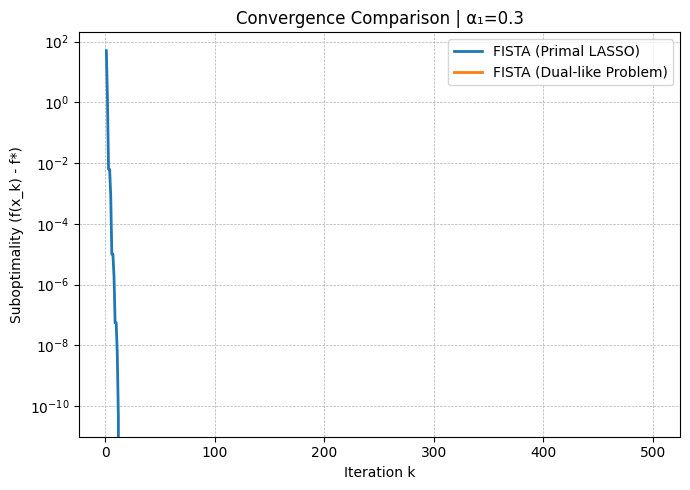

--- α₁=0.5 ---
Primal (FISTA) final objective: 7.108271
Dual-like (FISTA) final objective: 935.443281


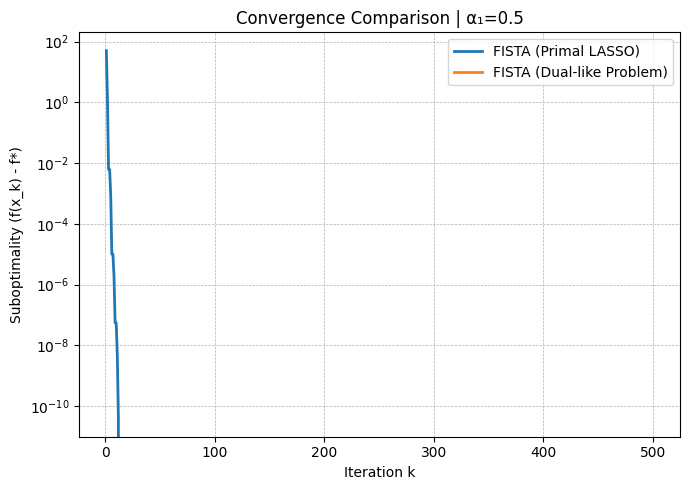

--- α₁=0.8 ---
Primal (FISTA) final objective: 8.973420
Dual-like (FISTA) final objective: 1411.028981


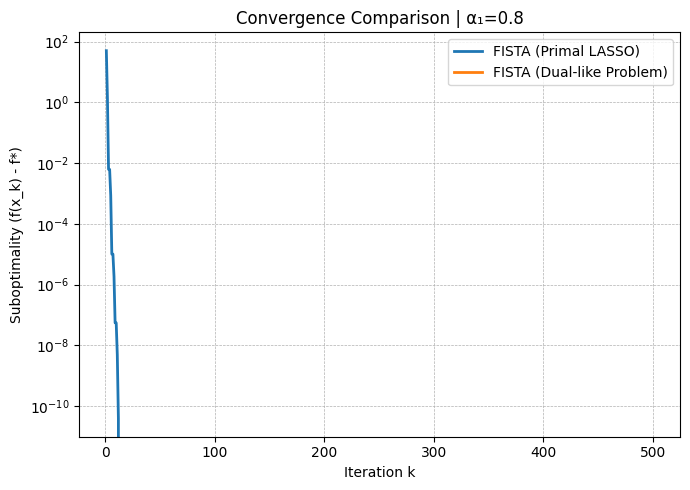

--- α₁=1.0 ---
Primal (FISTA) final objective: 10.216551
Dual-like (FISTA) final objective: 1695.598870


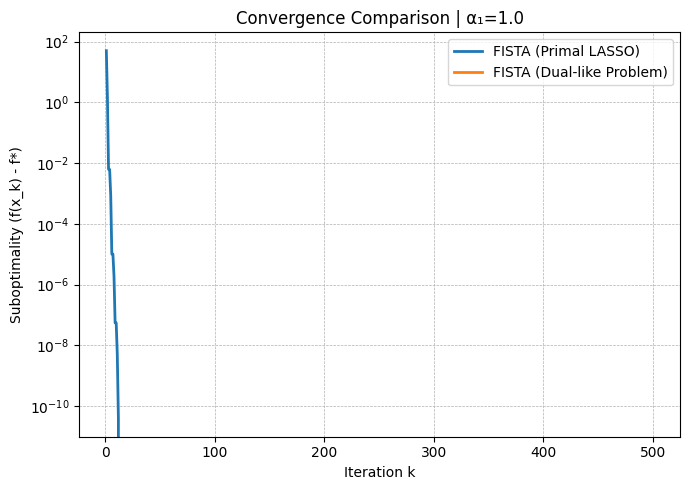


--- Final Results ---
        problem method   alpha1  n_iter     f_final
0  Primal LASSO  FISTA 0.300000      13    5.864538
1     Dual-like  FISTA 0.300000     500  583.772182
2  Primal LASSO  FISTA 0.500000      13    7.108271
3     Dual-like  FISTA 0.500000     500  935.443281
4  Primal LASSO  FISTA 0.800000      13    8.973420
5     Dual-like  FISTA 0.800000     500 1411.028981
6  Primal LASSO  FISTA 1.000000      13   10.216551
7     Dual-like  FISTA 1.000000     500 1695.598870


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iterative_solvers import fista
from dual_fista import dual_fista # Use the corrected version above
from objective_functions import compute_objective
from easy_boston_data import generate_easy_boston_like_data

# --- Data Setup ---
A, b, _ = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A = (A - A.mean(0)) / A.std(0)
b = b - b.mean()

alphas = [0.3, 0.5, 0.8, 1.0]
records = []

for a1 in alphas:
    print(f"--- α₁={a1} ---")

    # --- FISTA (Primal LASSO) ---
    _, obj_fista = fista(A, b, reg_type="lasso",
                         alpha1=a1, alpha2=0.0, max_iter=500)
    P_star = obj_fista[-1]
    print(f"Primal (FISTA) final objective: {P_star:.6f}")

    # --- Dual FISTA (Solving a DIFFERENT problem) ---
    λ, D_vals, _ = dual_fista(A, b, alpha1=a1, max_iter=500)
    D_fake_star = D_vals[-1]
    print(f"Dual-like (FISTA) final objective: {D_fake_star:.6f}")


    # --- Plotting Suboptimality for each problem ---
    ks_f = np.arange(1, len(obj_fista) + 1)
    ks_d = np.arange(1, len(D_vals) + 1)
    
    # Primal suboptimality: how far is each iteration from the final primal value
    env_f = np.minimum.accumulate(obj_fista - P_star)
    
    # Dual-like suboptimality: how far is each iteration from the final dual-like value
    env_d = np.minimum.accumulate(D_vals - D_fake_star)

    plt.figure(figsize=(7, 5))
    plt.semilogy(ks_f, env_f, '-', label="FISTA (Primal LASSO)", linewidth=2)
    plt.semilogy(ks_d, env_d, '-', label="FISTA (Dual-like Problem)", linewidth=2)
    plt.title(f"Convergence Comparison | α₁={a1}")
    plt.xlabel("Iteration k")
    plt.ylabel("Suboptimality (f(x_k) - f*)")
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    records += [
        {"problem": "Primal LASSO", "method": "FISTA", "alpha1": a1, "n_iter": len(obj_fista), "f_final": P_star},
        {"problem": "Dual-like", "method": "FISTA", "alpha1": a1, "n_iter": len(D_vals), "f_final": D_fake_star}
    ]

df = pd.DataFrame(records)
pd.set_option('display.float_format', '{:.6f}'.format)
print("\n--- Final Results ---")
print(df)